In [1]:
pip install pandas scikit-learn matplotlib seaborn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace this with your actual DataFrame)
# Make sure you provide the dataset as a pandas DataFrame
# Example: df = pd.read_csv('your_dataset.csv')
df = pd.read_csv('dim_places.csv')



In [8]:
df['contract_start'] = pd.to_datetime(df['contract_start'], errors='coerce')
df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce')

# Number of days active and inactive
df['days_active'] = (pd.Timestamp.now() - df['contract_start']).dt.days.fillna(0)
df['days_inactive'] = (pd.Timestamp.now() - df['termination_date']).dt.days.fillna(0)

# Fill NaN or null values in relevant columns with 0
flags = ['days_active',
    'days_inactive',
    'accepting_orders',
    'dormant',
    'seasonal',
    'daily_sales_reports',
    'activated',
    'binding_period',
    'auto_accept_delivery',
    'auto_accept_takeaway',
    'non_eu_commission',
    'processing_fee',
    'service_charge',
    'vat',
    'area_id',
    'takeaway',
    'delivery',
    'eat_in',
    'sales_outcome_id',
    'dormant_partner']
df[flags] = df[flags].fillna(0).astype(int)


In [9]:
import json

def extract_hours(row):
    try:
        open_data = json.loads(row)
        total_hours = 0
        for day, schedule in open_data.items():
            if schedule['from'] != 'closed':
                total_hours += float(schedule['to'].split('.')[0]) - float(schedule['from'].split('.')[0])
        return total_hours
    except:
        return 0

df['total_open_hours'] = df['opening_hours'].apply(extract_hours)

In [21]:
features = [
    'days_active',
    'days_inactive',
    'accepting_orders',
    'dormant',
    'seasonal',
    'daily_sales_reports',
    'activated',
    'binding_period',
    'auto_accept_delivery',
    'auto_accept_takeaway',
    'non_eu_commission',
    'processing_fee',
    'service_charge',
    'vat',
    'area_id',
    'takeaway',
    'delivery',
    'eat_in',
    'sales_outcome_id',
    'dormant_partner'
]

feature_weights = {
    'days_active': 3.0,
    'days_inactive': 2.5,
    'accepting_orders': 4.0,

   'daily_sales_reports': 3.0,

    'service_charge': 1.5,
    'takeaway': 2.0,
    'delivery': 2.0,

    'dormant': 4.0,
    'seasonal': 5.0,
    'activated': 3.5

}

X = df[features]

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
for feature, weight in feature_weights.items():
    col_idx = X.columns.get_loc(feature)  # Get the index of the feature
    X_scaled[:, col_idx] *= weight
# K-Means Clustering
# -----------------
# Fit the K-Means model and find optimal clusters
n_clusters = 5   # Define the number of clusters (3 is a good starting point, but use experimentation)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)




In [23]:
# Visualize Cluster Assignments
# -----------------
# Use Principal Component Analysis (PCA) to reduce dimensions and plot clusters
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the DataFrame
df['pca_one'] = X_pca[:, 0]
df['pca_two'] = X_pca[:, 1]


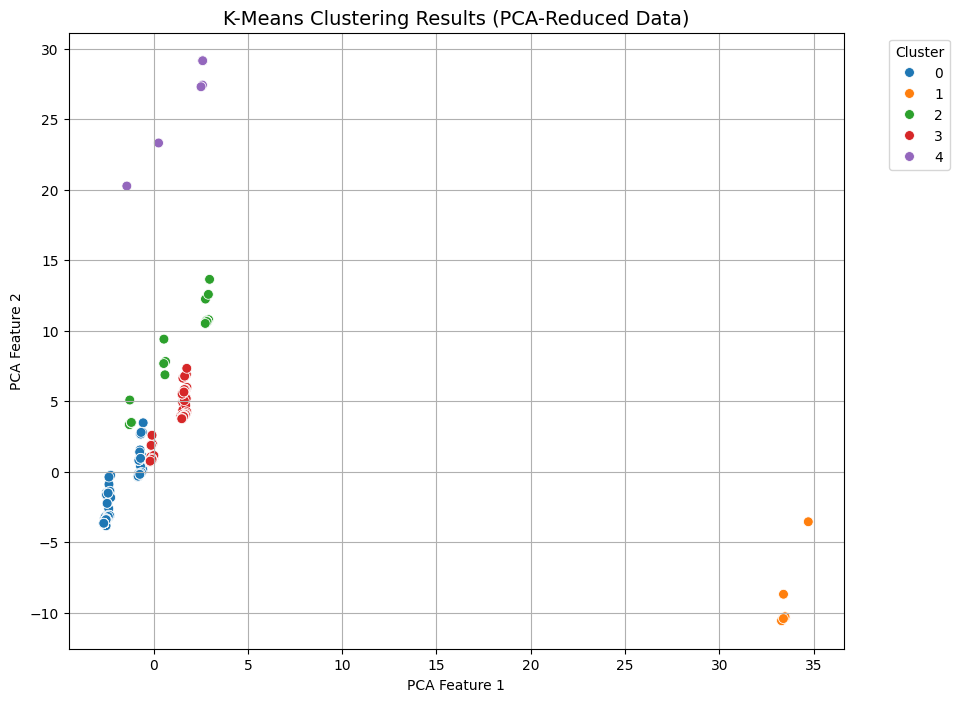


Cluster Distributions:
cluster
0    964
3    784
1     37
2     32
4      7
Name: count, dtype: int64

Cluster Summary (Average Features per Cluster):
          days_active  days_inactive  accepting_orders  dormant  seasonal  \
cluster                                                                     
0         2040.298755    1253.933610          1.000000      0.0       0.0   
1        20488.000000       0.000000          0.972973      0.0       1.0   
2        12805.000000    2561.000000          0.000000      0.0       0.0   
3        17169.153061    1228.234694          1.000000      0.0       0.0   
4        17561.142857       0.000000          1.000000      1.0       0.0   

         daily_sales_reports  activated  binding_period  auto_accept_delivery  \
cluster                                                                         
0                   0.932573   0.000000       35.572614              0.987552   
1                   0.972973   1.000000       36.000000          

In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_one', y='pca_two', hue='cluster', palette='tab10', s=50)
plt.title("K-Means Clustering Results (PCA-Reduced Data)", fontsize=14)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Analyze Results
# -----------------
# Check cluster assignments for trends and patterns
print("\nCluster Distributions:")
print(df['cluster'].value_counts())

# Check aggregate feature values for each cluster
cluster_summary = df.groupby('cluster')[features].mean()
print("\nCluster Summary (Average Features per Cluster):")
print(cluster_summary)

In [15]:
df.to_csv("clustered_results.csv", index=False)